In [1]:
from maskrcnn_benchmark.config import cfg

config_file = "/home/bengio/cells/maskrcnn-benchmark/tools/cell_config.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

In [2]:
import cv2
import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util


class Resize(object):
    def __init__(self, min_size, max_size):
        self.min_size = min_size
        self.max_size = max_size

    # modified from torchvision to add support for max size
    def get_size(self, image_size):
        w, h = image_size
        size = self.min_size
        max_size = self.max_size
        if max_size is not None:
            min_original_size = float(min((w, h)))
            max_original_size = float(max((w, h)))
            if max_original_size / min_original_size * size > max_size:
                size = int(round(max_size * min_original_size / max_original_size))

        if (w <= h and w == size) or (h <= w and h == size):
            return (h, w)

        if w < h:
            ow = size
            oh = int(size * h / w)
        else:
            oh = size
            ow = int(size * w / h)

        return (oh, ow)

    def __call__(self, image):
        size = self.get_size(image.size)
        image = F.resize(image, size)
        return image


class COCODemo(object):
    # COCO categories for pretty print
    CATEGORIES = [
        "__background",
        "cell"
    ]

    def __init__(
        self,
        cfg,
        confidence_threshold=0.7,
        show_mask_heatmaps=False,
        masks_per_dim=2,
        min_image_size=224,
    ):
        self.cfg = cfg.clone()
        self.model = build_detection_model(cfg)
        self.model.eval()
        self.device = torch.device(cfg.MODEL.DEVICE)
        self.model.to(self.device)
        self.min_image_size = min_image_size

        save_dir = cfg.OUTPUT_DIR
        checkpointer = DetectronCheckpointer(cfg, self.model, save_dir=save_dir)
        _ = checkpointer.load(cfg.MODEL.WEIGHT)

        self.transforms = self.build_transform()

        mask_threshold = -1 if show_mask_heatmaps else 0.5
        self.masker = Masker(threshold=mask_threshold, padding=1)

        # used to make colors for each class
        self.palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])

        self.cpu_device = torch.device("cpu")
        self.confidence_threshold = confidence_threshold
        self.show_mask_heatmaps = show_mask_heatmaps
        self.masks_per_dim = masks_per_dim

    def build_transform(self):
        """
        Creates a basic transformation that was used to train the models
        """
        cfg = self.cfg

        # we are loading images with OpenCV, so we don't need to convert them
        # to BGR, they are already! So all we need to do is to normalize
        # by 255 if we want to convert to BGR255 format, or flip the channels
        # if we want it to be in RGB in [0-1] range.
        if cfg.INPUT.TO_BGR255:
            to_bgr_transform = T.Lambda(lambda x: x * 255)
        else:
            to_bgr_transform = T.Lambda(lambda x: x[[2, 1, 0]])

        normalize_transform = T.Normalize(
            mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD
        )
        min_size = cfg.INPUT.MIN_SIZE_TEST
        max_size = cfg.INPUT.MAX_SIZE_TEST
        transform = T.Compose(
            [
                T.ToPILImage(),
                Resize(min_size, max_size),
                T.ToTensor(),
                to_bgr_transform,
                normalize_transform,
            ]
        )
        return transform

    def run_on_opencv_image(self, image):
        """
        Arguments:
            image (np.ndarray): an image as returned by OpenCV

        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        predictions = self.compute_prediction(image)
        top_predictions = self.select_top_predictions(predictions)
        print('top_predictions', top_predictions)
        
        result = image.copy()
        if self.show_mask_heatmaps:
            return self.create_mask_montage(result, top_predictions)
        result = self.overlay_boxes(result, top_predictions)
        if self.cfg.MODEL.MASK_ON:
            result = self.overlay_mask(result, top_predictions)
        if self.cfg.MODEL.KEYPOINT_ON:
            result = self.overlay_keypoints(result, top_predictions)
        result = self.overlay_class_names(result, top_predictions)

        return result

    def compute_prediction(self, original_image):
        """
        Arguments:
            original_image (np.ndarray): an image as returned by OpenCV

        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        # apply pre-processing to image
        print('tranformations', self.transforms)
        image = self.transforms(original_image)
        # convert to an ImageList, padded so that it is divisible by
        # cfg.DATALOADER.SIZE_DIVISIBILITY
        image_list = to_image_list(image, self.cfg.DATALOADER.SIZE_DIVISIBILITY)
        image_list = image_list.to(self.device)
        # compute predictions
        with torch.no_grad():
            predictions = self.model(image_list)
        predictions = [o.to(self.cpu_device) for o in predictions]

        # always single image is passed at a time
        prediction = predictions[0]

        # reshape prediction (a BoxList) into the original image size
        height, width = original_image.shape[:-1]
        prediction = prediction.resize((width, height))

        if prediction.has_field("mask"):
            # if we have masks, paste the masks in the right position
            # in the image, as defined by the bounding boxes
            masks = prediction.get_field("mask")
            # always single image is passed at a time
            masks = self.masker([masks], [prediction])[0]
            prediction.add_field("mask", masks)
        return prediction

    def select_top_predictions(self, predictions):
        """
        Select only predictions which have a `score` > self.confidence_threshold,
        and returns the predictions in descending order of score

        Arguments:
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `scores`.

        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        scores = predictions.get_field("scores")
        keep = torch.nonzero(scores > self.confidence_threshold).squeeze(1)
        predictions = predictions[keep]
        scores = predictions.get_field("scores")
        _, idx = scores.sort(0, descending=True)
        return predictions[idx]

    def compute_colors_for_labels(self, labels):
        """
        Simple function that adds fixed colors depending on the class
        """
        colors = labels[:, None] * self.palette
        colors = (colors % 255).numpy().astype("uint8")
        return colors

    def overlay_boxes(self, image, predictions):
        """
        Adds the predicted boxes on top of the image

        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `labels`.
        """
        labels = predictions.get_field("labels")
        boxes = predictions.bbox

        colors = self.compute_colors_for_labels(labels).tolist()

        for box, color in zip(boxes, colors):
            box = box.to(torch.int64)
            top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
            image = cv2.rectangle(
                image, tuple(top_left), tuple(bottom_right), tuple(color), 1
            )

        return image

    def overlay_mask(self, image, predictions):
        """
        Adds the instances contours for each predicted object.
        Each label has a different color.

        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `mask` and `labels`.
        """
        masks = predictions.get_field("mask").numpy()
        labels = predictions.get_field("labels")

        colors = self.compute_colors_for_labels(labels).tolist()

        for mask, color in zip(masks, colors):
            thresh = mask[0, :, :, None]
            contours, hierarchy = cv2_util.findContours(
                thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            image = cv2.drawContours(image, contours, -1, color, 3)

        composite = image

        return composite

    def overlay_keypoints(self, image, predictions):
        keypoints = predictions.get_field("keypoints")
        kps = keypoints.keypoints
        scores = keypoints.get_field("logits")
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            image = vis_keypoints(image, region.transpose((1, 0)))
        return image

    def create_mask_montage(self, image, predictions):
        """
        Create a montage showing the probability heatmaps for each one one of the
        detected objects

        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `mask`.
        """
        masks = predictions.get_field("mask")
        masks_per_dim = self.masks_per_dim
        masks = L.interpolate(
            masks.float(), scale_factor=1 / masks_per_dim
        ).byte()
        height, width = masks.shape[-2:]
        max_masks = masks_per_dim ** 2
        masks = masks[:max_masks]
        # handle case where we have less detections than max_masks
        if len(masks) < max_masks:
            masks_padded = torch.zeros(max_masks, 1, height, width, dtype=torch.uint8)
            masks_padded[: len(masks)] = masks
            masks = masks_padded
        masks = masks.reshape(masks_per_dim, masks_per_dim, height, width)
        result = torch.zeros(
            (masks_per_dim * height, masks_per_dim * width), dtype=torch.uint8
        )
        for y in range(masks_per_dim):
            start_y = y * height
            end_y = (y + 1) * height
            for x in range(masks_per_dim):
                start_x = x * width
                end_x = (x + 1) * width
                result[start_y:end_y, start_x:end_x] = masks[y, x]
        return cv2.applyColorMap(result.numpy(), cv2.COLORMAP_JET)

    def overlay_class_names(self, image, predictions):
        """
        Adds detected class names and scores in the positions defined by the
        top-left corner of the predicted bounding box

        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `scores` and `labels`.
        """
        scores = predictions.get_field("scores").tolist()
        labels = predictions.get_field("labels").tolist()
        labels = [self.CATEGORIES[i] for i in labels]
        boxes = predictions.bbox

        template = "{}: {:.2f}"
        for box, score, label in zip(boxes, scores, labels):
            x, y = box[:2]
            s = template.format(label, score)
            cv2.putText(
                image, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1
            )

        return image

In [3]:
import cv2
from PIL import Image

coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)


In [4]:
import torch
from torchvision.transforms import functional as F


# load image and then run prediction
img_path = '/home/bengio/cells/Usiigaci/Mask R-CNN/val/set47/raw.tif'
image = cv2.imread(img_path)[:1022, :1022]
# cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
# image = F.to_tensor(Image.fromarray(cv_img))
# image = Image.fromarray(cv_img)


In [61]:
predictions = coco_demo.run_on_opencv_image(image)

tranformations Compose(
    ToPILImage()
    ToTensor()
    Lambda()
    Normalize(mean=[102.9801, 115.9465, 122.7717], std=[1.0, 1.0, 1.0])
)
top_predictions BoxList(num_boxes=4, image_width=1022, image_height=1022, mode=xyxy)


In [62]:
type(predictions)

numpy.ndarray

In [63]:
predictions.shape

(1022, 1022, 3)

In [64]:
import matplotlib.pyplot as plt

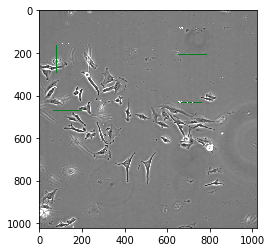

In [65]:
plt.imshow(predictions)

In [66]:
cv2.imwrite('set47_aug_iter19000_pred.png', predictions)

True